<a href="https://colab.research.google.com/github/na0260/data-minig-lab/blob/main/LabReport4DM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Stacking Ensemble Accuracy: 0.74
AdaBoost Ensemble Accuracy: 0.67


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


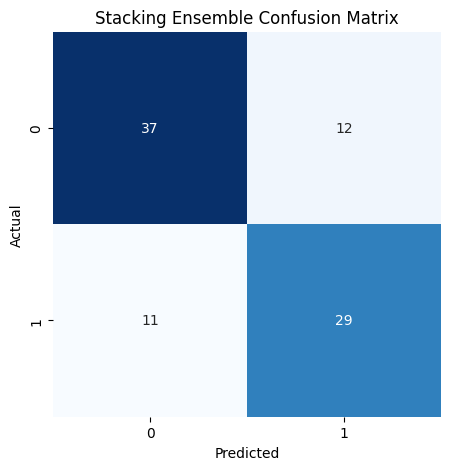

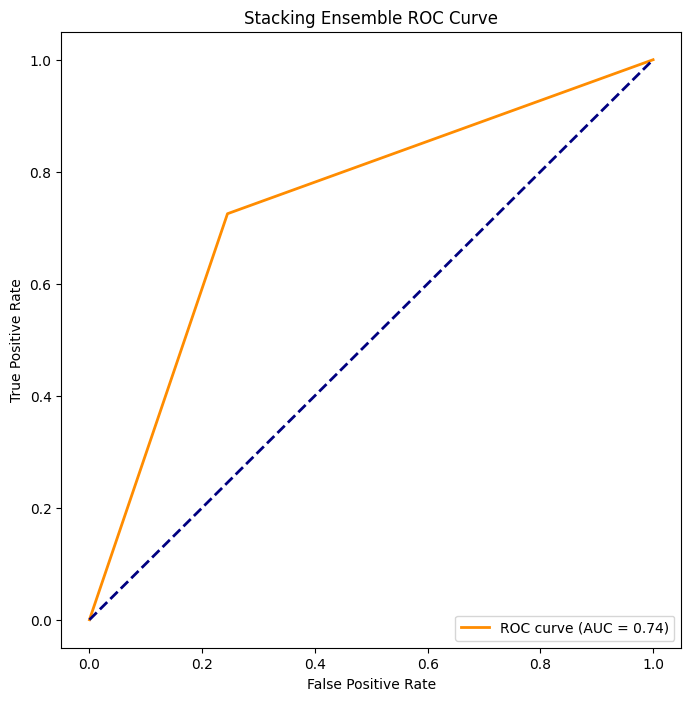

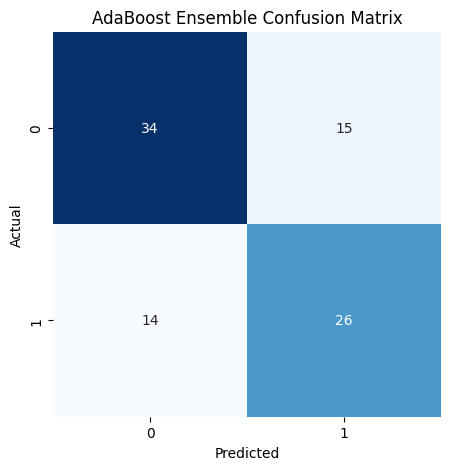

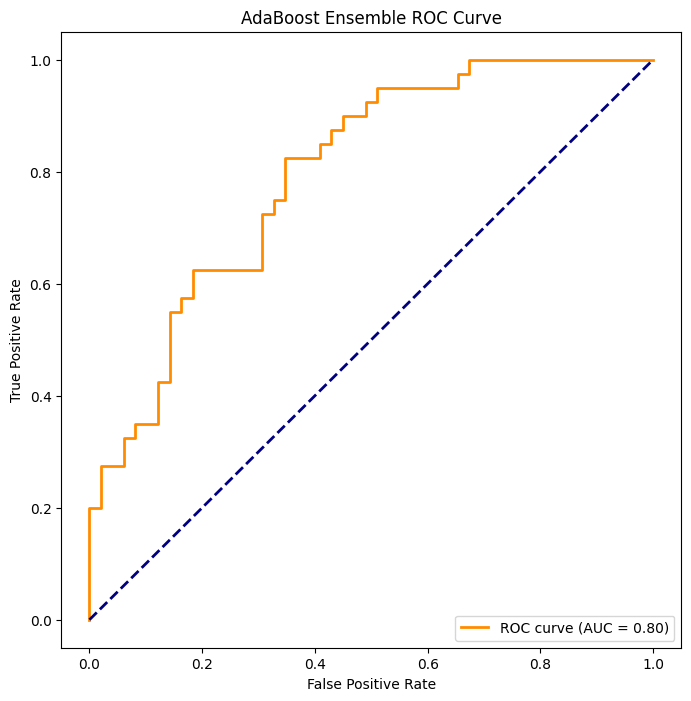

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.datasets import load_diabetes
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc
import seaborn as sns

diabetes = load_diabetes()
X, y = diabetes.data, diabetes.target

y_binary = (y > np.median(y)).astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y_binary, test_size=0.2, random_state=42)


scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

base_models = [
    RandomForestClassifier(n_estimators=100, random_state=42),
    GradientBoostingClassifier(n_estimators=100, random_state=42)
]

meta_model = LogisticRegression()

def stacking_ensemble(X_train, y_train, X_test, base_models, meta_model):
    meta_features_train = np.zeros((len(X_train), len(base_models)))

    for i, model in enumerate(base_models):
        model.fit(X_train, y_train)
        meta_features_train[:, i] = cross_val_predict(model, X_train, y_train, cv=StratifiedKFold(n_splits=5), method='predict_proba')[:, 1]

    meta_model.fit(meta_features_train, y_train)

    meta_features_test = np.zeros((len(X_test), len(base_models)))

    for i, model in enumerate(base_models):
        meta_features_test[:, i] = model.predict_proba(X_test)[:, 1]

    y_pred = meta_model.predict(meta_features_test)

    return y_pred

stacking_predictions = stacking_ensemble(X_train, y_train, X_test, base_models, meta_model)

stacking_accuracy = accuracy_score(y_test, stacking_predictions)
print(f"Stacking Ensemble Accuracy: {stacking_accuracy:.2f}")


adaboost_model = AdaBoostClassifier(
    base_estimator=DecisionTreeClassifier(max_depth=1),
    n_estimators=50,
    random_state=42
)
adaboost_model.fit(X_train, y_train)

adaboost_predictions = adaboost_model.predict(X_test)

adaboost_accuracy = accuracy_score(y_test, adaboost_predictions)
print(f"AdaBoost Ensemble Accuracy: {adaboost_accuracy:.2f}")

plot_confusion_matrix(y_test, stacking_predictions, title="Stacking Ensemble Confusion Matrix")
plot_roc_curve(y_test, stacking_predictions, title="Stacking Ensemble ROC Curve")

plot_confusion_matrix(y_test, adaboost_predictions, title="AdaBoost Ensemble Confusion Matrix")
plot_roc_curve(y_test, adaboost_model.predict_proba(X_test)[:, 1], title="AdaBoost Ensemble ROC Curve")